# Постановка задачи

Есть тексты с меткой спам и не спам. Необходимо обучить модель классифицировать текст. Целевая метрика - ROC-AUC.

# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
from tqdm.auto import tqdm
from itertools import product
import random
import warnings

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer, normalize
from sklearn.compose import ColumnTransformer
import optuna
from optuna.samplers import TPESampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)
from sklearn.metrics import (f1_score, classification_report, roc_auc_score, auc, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 1
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [4]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')
print(train.shape)
print(test.shape)

(16278, 2)
(4070, 1)


In [5]:
train.sample(5)

,text_type,text
3160,ham,i hope you thats the result of being consisten...
4036,ham,grades thank you you have been wonderful to wo...
7301,ham,but if theres a steal deal on laptops do tell me
11829,spam,best cum all videos available here over newly ...
9921,ham,i wil leave sumthng 4u wen i wil leave dis wor...


In [6]:
test.sample(5)

,text
868,o to on your devices browse
955,i didnt get ur full msgsometext is missing sen...
1859,recruiting for weather risk management group h...
1119,organizational changes we are making a number ...
3359,hey anyway i have to


In [7]:
train.isnull().sum()

text_type    0
text         0
dtype: int64

In [8]:
print(train['text_type'].unique())
print(train['text_type'].value_counts())

['ham' 'spam']
ham     11469
spam     4809
Name: text_type, dtype: int64


In [9]:
test.isnull().sum()

text    0
dtype: int64

Задача бинарной классификации. Метки целевого класса: Spam - 1, ham - 0. Целевой класс несбалансирован. 

# Предобработка данных

In [10]:
train['target'] = train['text_type'].map({'spam': 1, 'ham': 0})

In [11]:
class_disbalance = round(len(train[train['target'] == 0])/len(train[train['target'] == 1]), 2)
class_disbalance

2.38

In [12]:
train.groupby('target').describe()

text_type                       text         \
           count unique   top   freq  count unique   
target                                               
0          11469      1   ham  11469  11469  11458   
1           4809      1  spam   4809   4809   4809   

                                                                
                                                      top freq  
target                                                          
0       SPAM ALERT  🚔  User:     Username: @DillyBubbl...    7  
1       plzz visit my website moviesgodml to get all m...    1

Посмотрю на облака слов необработанного текста.

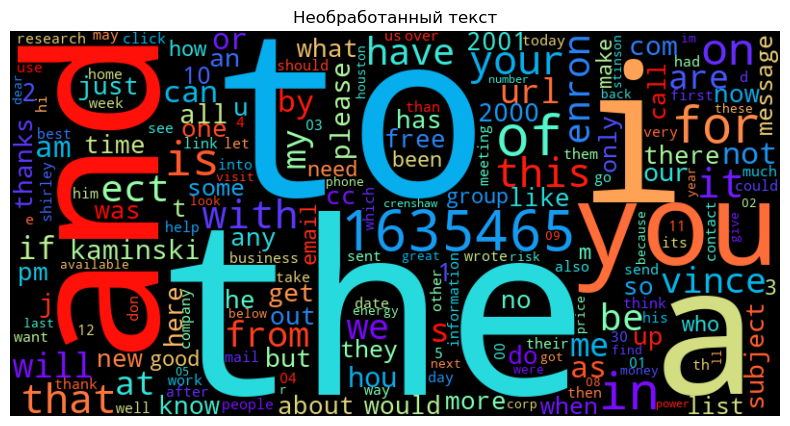

In [13]:
text_toxic = ' '.join(train['text'])
words = text_toxic.split()
word_freq = {}
for word in words:
    word_freq[word] = word_freq.get(word, 0) + 1
wordcloud = WordCloud(width=800, 
                      height=400,
                     colormap='rainbow').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Необработанный текст')
plt.axis("off")
plt.show()

## Лемматизация

В тектовых данных есть разделители, числа, символы, заглавные символы. Очищу данные и приведу к нижнему регистру. Удалю стоп-слова английского языка в тексте и лемматизирую текст.

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) \
              for word in tokens if word.isalnum() and word.isalpha() and len(word)>3]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [16]:
train['text_clean'] = train['text'].apply(preprocess)

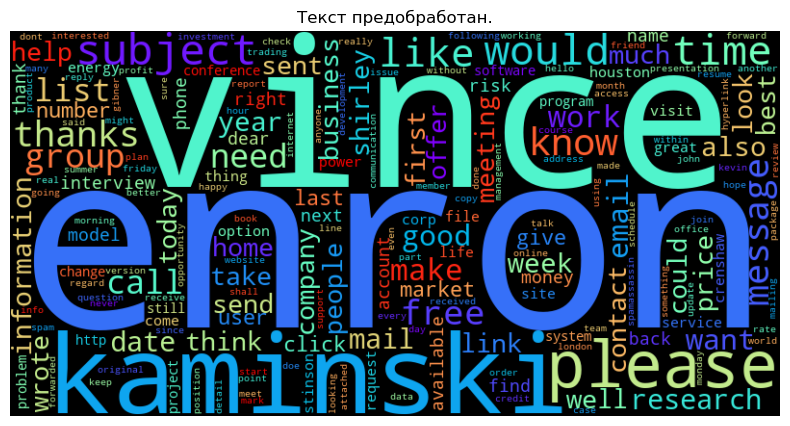

In [17]:
text_toxic = ' '.join(train['text_clean'])
words = text_toxic.split()
word_freq = {}
for word in words:
    word_freq[word] = word_freq.get(word, 0) + 1
wordcloud = WordCloud(width=800, 
                      height=400,
                     colormap='rainbow').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Текст предобработан.')
plt.show()

Максимальное количество слов в лемматизированном тексте - 94, будем это учитывать при векторизации.

In [18]:
train['text_clean'].duplicated().sum()

570

In [19]:
train[['text_clean', 'target']].duplicated().sum()

560

Есть дубликаты. Удалим их.

In [20]:
train = train.drop_duplicates(subset='text_clean')

In [21]:
# максимальная длина предобработанного текста
max(map(lambda text: len(text.split()), train['text_clean']))

94

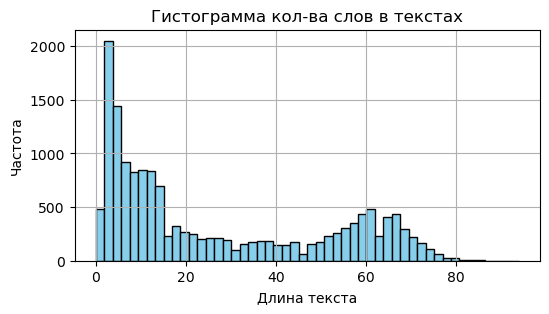

In [22]:
train['text_length'] = train['text_clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 3))
plt.hist(train['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Гистограмма кол-ва слов в текстах')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [23]:
word_counts = Counter()
for text in train['text_clean']:
    words = text.split()
    word_counts.update(words)
print('Наиболее часто встречающиеся слова:')
print(word_counts.most_common(20))
print('Количество уникальных слов:', len(word_counts))

Наиболее часто встречающиеся слова:
[('enron', 4793), ('vince', 4476), ('kaminski', 2337), ('please', 2321), ('subject', 2177), ('would', 2028), ('time', 2017), ('like', 1836), ('know', 1692), ('thanks', 1533), ('message', 1528), ('free', 1427), ('group', 1400), ('need', 1342), ('list', 1305), ('call', 1297), ('work', 1177), ('make', 1167), ('want', 1114), ('email', 1105)]
Количество уникальных слов: 39624


In [24]:
#очистка текста в тестовой выборке
test['text_clean'] = test['text'].apply(preprocess)

## Деление на выборки

Деление на выборки: train/test 90/10. Выбираю лучшую модель на кросс-валидации. Имеем несбалансированный целевой класс, метрика модели - f1, c beta=1.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train['text_clean'], 
                                                    train['target'], 
                                                    test_size=0.10,
                                                    stratify=train['target'],
                                                    random_state=RANDOM_STATE, shuffle=True)

## Векторизация текста

Для векторизации текста воспользуюсь методами TF-IFD, Word2Vec (из gensim) и Bert (unitary/toxic-bert, обучен на спам-текстах).

### TF-IDF векторизация

In [26]:
tfidf = TfidfVectorizer(min_df=1e-3,
                        max_df=0.8,
                        ngram_range=(1, 5),
                        use_idf=True,
                        smooth_idf=True,
                        norm='l2')

In [27]:
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print('Tfidf_train:', tfidf_train.shape)
print('Tfidf_test:', tfidf_test.shape)

Tfidf_train: (14137, 5197)
Tfidf_test: (1571, 5197)


Примерно ~5к признаков. Данных ~ 16к.

In [28]:
#количество ненулевых значений в матрице для обучения
print('Кол-во ненулевых значений:', tfidf_train.nnz)
print('Разряженность матрицы: {:.2f} %'.format(
    tfidf_train.nnz*100/(tfidf_train.shape[0]*tfidf_train.shape[1])))

Кол-во ненулевых значений: 292088
Разряженность матрицы: 0.40 %


### Word2Vec

Воспользуюсь предобученной моделью word2vec от google из б-ки gensim.

In [29]:
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=120, window=2, min_count=10, workers=5)

In [30]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(120)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

w2v_train = np.array([vectorize(sentence) for sentence in X_train])
w2v_test = np.array([vectorize(sentence) for sentence in X_test])

### Bert

Реализацию с предобученной моделью Bert для спам-текстов не удалось запустить даже на kaggle... 

In [31]:
#bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [32]:
#def tokenize_text_bert(text):
#    inputs = bert_tokenizer(text, padding=True, max_length=512, truncation=True, return_tensors="pt")
#    return inputs

In [33]:
#bert_train = np.array([bert_tokenizer(sentence) for sentence in X_train])
#bert_test = np.array([bert_tokenizer(sentence) for sentence in X_test])

In [34]:
#bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

### N-gram

Преобразую тектстовые данные в вектора посредством n-gram.

In [35]:
n2gram_vectorizer = CountVectorizer(ngram_range=(1, 2))
n3gram_vectorizer = CountVectorizer(ngram_range=(1, 3))

n2gram_train = normalize(n2gram_vectorizer.fit_transform(X_train), norm='l2')
n3gram_train = normalize(n3gram_vectorizer.fit_transform(X_train), norm='l2')

n2gram_test = normalize(n2gram_vectorizer.transform(X_test), norm='l2')
n3gram_test = normalize(n3gram_vectorizer.transform(X_test), norm='l2')

## Обучение модели

Для подбора оптимального метода (LogisticRegression, RandomForest,  MultinomialNB, LinearSVC, LGBM) обучения модели и гиперпараметров использую optuna. Так как данные векторизировались 3 методами - tf-idf, Word2Vec и n-gram-ми, то в таком порядке обучаю модели на разнных данных и затем результаты заношу в таблицу с наилучшей метрикой ROC-AUC и лучшими гиперпараметрами модели с меткой, указывающей на векторизацию.

In [36]:
def objective(trial, model, params, X_train, y_train, cv):
    for param, options in params.items():
        if isinstance(options, tuple):
            trial_value = trial.suggest_int(param, options[0], options[-1])
        else:
            trial_value = trial.suggest_categorical(param, options)
        model.set_params(**{param: trial_value})
    pipeline = Pipeline(steps=[('model', model)])
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    return f1_scores.mean()

In [37]:
def model_train(trials, model, params, X_train, y_train, cv):
    sampler = TPESampler(seed=RANDOM_STATE)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    optimize_func = lambda trial: objective(trial=trial, 
                                            model=model,
                                            params=params, 
                                            X_train=X_train, 
                                            y_train=y_train, cv=cv) 
    with tqdm(total=trials) as pbar:
        def callback(study, trial):
            pbar.update(1)
    
        study.optimize(optimize_func, n_trials=trials, callbacks=[callback])
    print('Наиучшая метрика:', round(study.best_value, 3))
    print('Лучшие параметры модели:', study.best_params)
    
    return study.best_params, study.best_value

### Const-model

In [38]:
#предсказание случайным образом 0, 1
y_pred = np.random.randint(2, size=len(y_train))
score_baseline = roc_auc_score(y_train, y_pred)
print("ROC-AUC:", round(score_baseline, 3))

ROC-AUC: 0.506


In [39]:
#датафрейм с результатами
results = pd.DataFrame([], columns=['model', 'params', 'ROC-AUC', 'vec_method'])

In [40]:
results.loc[len(results.index)] = ['baseline', [], score_baseline, '']
results

,model,params,ROC-AUC,vec_method
0,baseline,[],0.506204,


In [41]:
results

,model,params,ROC-AUC,vec_method
0,baseline,[],0.506204,


### LogisticRegression()

In [42]:
model = LogisticRegression()
lr_params = {'C': (0, 1000), 'penalty': ['l1', 'l2'], 'max_iter': (100, 1000), 
              'solver': ['liblinear', 'liblinear'], 'random_state': [RANDOM_STATE],
              'class_weight' : ['balanced', None]}

In [43]:
lr_best_params, lr_best_score = model_train(trials=10, model=model,
                                            params=lr_params, 
                                            X_train=tfidf_train, 
                                            y_train=y_train, cv=10)

[I 2024-05-03 19:30:12,272] A new study created in memory with name: no-name-b45b667e-7326-4181-82b1-e3c04dc96168


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-03 19:30:14,160] Trial 0 finished with value: 0.9220481996279375 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 372, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 0 with value: 0.9220481996279375.
[I 2024-05-03 19:30:15,892] Trial 1 finished with value: 0.9224119522952735 and parameters: {'C': 397, 'penalty': 'l1', 'max_iter': 717, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9224119522952735.
[I 2024-05-03 19:30:17,718] Trial 2 finished with value: 0.9220481996279375 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 278, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9224119522952735.
[I 2024-05-03 19:30:20,124] Trial 3 finished with value: 0.9182556382368837 and parameters: {'C': 877, 'penalty': 'l1', 'max_iter': 135, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9224119522952735.


Наиучшая метрика: 0.958
Лучшие параметры модели: {'C': 50, 'penalty': 'l2', 'max_iter': 563, 'solver': 'liblinear', 'random_state': 1, 'class_weight': 'balanced'}


In [44]:
results.loc[len(results.index)] = [LogisticRegression(), lr_best_params, lr_best_score, 'tf-idf']

In [45]:
lr_best_params, lr_best_score = model_train(trials=10, model=LogisticRegression(),
                                            params=lr_params, 
                                            X_train=n2gram_train, 
                                            y_train=y_train, cv=10)
results.loc[len(results.index)] = [LogisticRegression(), lr_best_params, lr_best_score, 'n2gram']

[I 2024-05-03 19:30:32,712] A new study created in memory with name: no-name-e86ebba8-9e90-4aa6-9839-bd9afc2de6b5


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-03 19:30:36,235] Trial 0 finished with value: 0.9654165598737736 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 372, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 0 with value: 0.9654165598737736.
[I 2024-05-03 19:30:39,909] Trial 1 finished with value: 0.9654900096202645 and parameters: {'C': 397, 'penalty': 'l1', 'max_iter': 717, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9654900096202645.
[I 2024-05-03 19:30:43,405] Trial 2 finished with value: 0.9654165598737736 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 278, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9654900096202645.
[I 2024-05-03 19:30:46,999] Trial 3 finished with value: 0.965604426901346 and parameters: {'C': 877, 'penalty': 'l1', 'max_iter': 135, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 3 with value: 0.965604426901346.
[I

Наиучшая метрика: 0.976
Лучшие параметры модели: {'C': 50, 'penalty': 'l2', 'max_iter': 563, 'solver': 'liblinear', 'random_state': 1, 'class_weight': 'balanced'}


In [46]:
lr_best_params, lr_best_score = model_train(trials=10, model=LogisticRegression(),
                                            params=lr_params, 
                                            X_train=n3gram_train, 
                                            y_train=y_train, cv=10)
results.loc[len(results.index)] = [LogisticRegression(), lr_best_params, lr_best_score, 'n3gram']

[I 2024-05-03 19:31:23,391] A new study created in memory with name: no-name-945fc7bb-2ce5-4394-9821-3c41ce3f4f91


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-03 19:31:30,303] Trial 0 finished with value: 0.9640566972199572 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 372, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 0 with value: 0.9640566972199572.
[I 2024-05-03 19:31:37,051] Trial 1 finished with value: 0.9641164460222578 and parameters: {'C': 397, 'penalty': 'l1', 'max_iter': 717, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9641164460222578.
[I 2024-05-03 19:31:43,992] Trial 2 finished with value: 0.9640566972199572 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 278, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9641164460222578.
[I 2024-05-03 19:31:51,238] Trial 3 finished with value: 0.9640314372604996 and parameters: {'C': 877, 'penalty': 'l1', 'max_iter': 135, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9641164460222578.


Наиучшая метрика: 0.974
Лучшие параметры модели: {'C': 50, 'penalty': 'l2', 'max_iter': 563, 'solver': 'liblinear', 'random_state': 1, 'class_weight': 'balanced'}


### RandomForest

In [47]:
model = RandomForestClassifier()
rf_params = {'n_estimators': (20, 350), 'max_depth': (2, 50), 'class_weight':['balanced', None],
              'min_impurity_decrease': (0.0, 1.0), 'min_samples_split': (2, 50), 'min_samples_leaf': (1, 50),
              'random_state': [RANDOM_STATE]}
rf_best_params, rf_best_score = model_train(trials=25, model=model, 
                                            params=rf_params, X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 19:32:53,327] A new study created in memory with name: no-name-1b62a00b-0f9c-431b-9a3c-5e63c245b307


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-05-03 19:33:00,128] Trial 0 finished with value: 0.9342161080245006 and parameters: {'n_estimators': 158, 'max_depth': 37, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 6, 'min_samples_leaf': 10, 'random_state': 1}. Best is trial 0 with value: 0.9342161080245006.
[I 2024-05-03 19:33:01,473] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 134, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 1, 'min_samples_split': 12, 'min_samples_leaf': 44, 'random_state': 1}. Best is trial 0 with value: 0.9342161080245006.
[I 2024-05-03 19:33:02,451] Trial 2 finished with value: 0.9136847480526165 and parameters: {'n_estimators': 29, 'max_depth': 34, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 11, 'min_samples_leaf': 41, 'random_state': 1}. Best is trial 0 with value: 0.9342161080245006.
[I 2024-05-03 19:33:05,865] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 340, 'max_depth': 17, '

Наиучшая метрика: 0.947
Лучшие параметры модели: {'n_estimators': 215, 'max_depth': 40, 'class_weight': 'balanced', 'min_impurity_decrease': 0, 'min_samples_split': 8, 'min_samples_leaf': 6, 'random_state': 1}


In [48]:
results.loc[len(results.index)] = [RandomForestClassifier(), rf_best_params, rf_best_score, 'tf-idf']

In [49]:
rf_best_params, rf_best_score = model_train(trials=25, model=model, 
                                            params=rf_params, X_train=w2v_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [RandomForestClassifier(), rf_best_params, rf_best_score, 'w2v']

[I 2024-05-03 19:35:35,457] A new study created in memory with name: no-name-a7230ea1-77e5-4338-b3ca-e6d1e5eb0827


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-05-03 19:36:48,947] Trial 0 finished with value: 0.9417984569696491 and parameters: {'n_estimators': 158, 'max_depth': 37, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 6, 'min_samples_leaf': 10, 'random_state': 1}. Best is trial 0 with value: 0.9417984569696491.
[I 2024-05-03 19:36:57,077] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 134, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 1, 'min_samples_split': 12, 'min_samples_leaf': 44, 'random_state': 1}. Best is trial 0 with value: 0.9417984569696491.
[I 2024-05-03 19:37:07,987] Trial 2 finished with value: 0.9305552005119028 and parameters: {'n_estimators': 29, 'max_depth': 34, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 11, 'min_samples_leaf': 41, 'random_state': 1}. Best is trial 0 with value: 0.9417984569696491.
[I 2024-05-03 19:37:28,764] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 340, 'max_depth': 17, '

Наиучшая метрика: 0.944
Лучшие параметры модели: {'n_estimators': 205, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 0, 'min_samples_split': 17, 'min_samples_leaf': 2, 'random_state': 1}


In [50]:
rf_best_params, rf_best_score = model_train(trials=15, model=RandomForestClassifier(), 
                                            params=rf_params, X_train=n2gram_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [RandomForestClassifier(), rf_best_params, rf_best_score, 'n2gram']

[I 2024-05-03 20:06:03,271] A new study created in memory with name: no-name-2f93cd93-0afb-442a-aa97-0d3e659c5f81


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-05-03 20:09:16,891] Trial 0 finished with value: 0.949749912448473 and parameters: {'n_estimators': 158, 'max_depth': 37, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 6, 'min_samples_leaf': 10, 'random_state': 1}. Best is trial 0 with value: 0.949749912448473.
[I 2024-05-03 20:09:24,361] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 134, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 1, 'min_samples_split': 12, 'min_samples_leaf': 44, 'random_state': 1}. Best is trial 0 with value: 0.949749912448473.
[I 2024-05-03 20:09:29,722] Trial 2 finished with value: 0.7609170567630297 and parameters: {'n_estimators': 29, 'max_depth': 34, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 11, 'min_samples_leaf': 41, 'random_state': 1}. Best is trial 0 with value: 0.949749912448473.
[I 2024-05-03 20:09:48,532] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 340, 'max_depth': 17, 'clas

Наиучшая метрика: 0.953
Лучшие параметры модели: {'n_estimators': 332, 'max_depth': 26, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 42, 'min_samples_leaf': 9, 'random_state': 1}


In [51]:
rf_best_params, rf_best_score = model_train(trials=15, model=RandomForestClassifier(), 
                                            params=rf_params, X_train=n3gram_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [RandomForestClassifier(), rf_best_params, rf_best_score, 'n3gram']

[I 2024-05-03 20:31:14,048] A new study created in memory with name: no-name-e07b938f-e19b-4a29-84e1-dca9b8e795eb


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-05-03 20:35:36,508] Trial 0 finished with value: 0.9522344826892606 and parameters: {'n_estimators': 158, 'max_depth': 37, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 6, 'min_samples_leaf': 10, 'random_state': 1}. Best is trial 0 with value: 0.9522344826892606.
[I 2024-05-03 20:35:47,633] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 134, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 1, 'min_samples_split': 12, 'min_samples_leaf': 44, 'random_state': 1}. Best is trial 0 with value: 0.9522344826892606.
[I 2024-05-03 20:35:52,735] Trial 2 finished with value: 0.6732192825897524 and parameters: {'n_estimators': 29, 'max_depth': 34, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 11, 'min_samples_leaf': 41, 'random_state': 1}. Best is trial 0 with value: 0.9522344826892606.
[I 2024-05-03 20:36:19,769] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 340, 'max_depth': 17, '

Наиучшая метрика: 0.955
Лучшие параметры модели: {'n_estimators': 332, 'max_depth': 25, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 42, 'min_samples_leaf': 9, 'random_state': 1}


### MultinomialNB

In [52]:
model = MultinomialNB() 
nb_params = {
    'alpha': (0.1, 100),
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.6, 0.4], [0.4, 0.6], [0.7, 0.3], [0.2, 0.8], [0.8, 0.2]] 
}
nb_best_params, nb_best_score = model_train(trials=20, model=model,
                                            params=nb_params, 
                                            X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 21:02:34,875] A new study created in memory with name: no-name-01a2101c-9c87-431c-be57-96dc7a58d13a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:02:34,924] Trial 0 finished with value: 0.9154831957966652 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': [0.8, 0.2]}. Best is trial 0 with value: 0.9154831957966652.
[I 2024-05-03 21:02:34,964] Trial 1 finished with value: 0.9154831957966652 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': None}. Best is trial 0 with value: 0.9154831957966652.
[I 2024-05-03 21:02:35,004] Trial 2 finished with value: 0.905783424328507 and parameters: {'alpha': 80, 'fit_prior': True, 'class_prior': [0.6, 0.4]}. Best is trial 0 with value: 0.9154831957966652.
[I 2024-05-03 21:02:35,044] Trial 3 finished with value: 0.9432190826584271 and parameters: {'alpha': 9, 'fit_prior': False, 'class_prior': [0.7, 0.3]}. Best is trial 3 with value: 0.9432190826584271.
[I 2024-05-03 21:02:35,081] Trial 4 finished with value: 0.9030991073467696 and parameters: {'alpha': 99, 'fit_prior': True, 'class_prior': [0.4, 0.6]}. Best is trial 3 with value: 0.9432190826584271.
[I

Наиучшая метрика: 0.961
Лучшие параметры модели: {'alpha': 1, 'fit_prior': True, 'class_prior': [0.8, 0.2]}


In [53]:
results.loc[len(results.index)] = [MultinomialNB(), nb_best_params, nb_best_score, 'tf-idf']

In [54]:
nb_best_params, nb_best_score = model_train(trials=20, model=MultinomialNB(),
                                            params=nb_params, 
                                            X_train=n2gram_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [MultinomialNB(), nb_best_params, nb_best_score, 'n2gram']

[I 2024-05-03 21:02:35,714] A new study created in memory with name: no-name-ae8e0e61-b3d8-418a-8c46-faaf5e1c4459


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:02:35,814] Trial 0 finished with value: 0.8444286292047973 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': [0.8, 0.2]}. Best is trial 0 with value: 0.8444286292047973.
[I 2024-05-03 21:02:35,905] Trial 1 finished with value: 0.8444286292047973 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': None}. Best is trial 0 with value: 0.8444286292047973.
[I 2024-05-03 21:02:35,994] Trial 2 finished with value: 0.8328872536004148 and parameters: {'alpha': 80, 'fit_prior': True, 'class_prior': [0.6, 0.4]}. Best is trial 0 with value: 0.8444286292047973.
[I 2024-05-03 21:02:36,081] Trial 3 finished with value: 0.8796865832194779 and parameters: {'alpha': 9, 'fit_prior': False, 'class_prior': [0.7, 0.3]}. Best is trial 3 with value: 0.8796865832194779.
[I 2024-05-03 21:02:36,176] Trial 4 finished with value: 0.8297291167031456 and parameters: {'alpha': 99, 'fit_prior': True, 'class_prior': [0.4, 0.6]}. Best is trial 3 with value: 0.8796865832194779.
[

Наиучшая метрика: 0.935
Лучшие параметры модели: {'alpha': 1, 'fit_prior': True, 'class_prior': [0.8, 0.2]}


In [55]:
nb_best_params, nb_best_score = model_train(trials=20, model=MultinomialNB(),
                                            params=nb_params, 
                                            X_train=n3gram_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [MultinomialNB(), nb_best_params, nb_best_score, 'n3gram']

[I 2024-05-03 21:02:37,606] A new study created in memory with name: no-name-e910da4e-5703-4087-b9e4-74fae70a5f83


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:02:37,750] Trial 0 finished with value: 0.8471230819308666 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': [0.8, 0.2]}. Best is trial 0 with value: 0.8471230819308666.
[I 2024-05-03 21:02:37,884] Trial 1 finished with value: 0.8471230819308666 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': None}. Best is trial 0 with value: 0.8471230819308666.
[I 2024-05-03 21:02:38,020] Trial 2 finished with value: 0.8357518206260733 and parameters: {'alpha': 80, 'fit_prior': True, 'class_prior': [0.6, 0.4]}. Best is trial 0 with value: 0.8471230819308666.
[I 2024-05-03 21:02:38,152] Trial 3 finished with value: 0.8819416060081984 and parameters: {'alpha': 9, 'fit_prior': False, 'class_prior': [0.7, 0.3]}. Best is trial 3 with value: 0.8819416060081984.
[I 2024-05-03 21:02:38,286] Trial 4 finished with value: 0.8326005549965381 and parameters: {'alpha': 99, 'fit_prior': True, 'class_prior': [0.4, 0.6]}. Best is trial 3 with value: 0.8819416060081984.
[

Наиучшая метрика: 0.938
Лучшие параметры модели: {'alpha': 1, 'fit_prior': True, 'class_prior': [0.8, 0.2]}


### LinearSVC

In [56]:
model = LinearSVC()
svc_params = {
    'C': (0, 100),
    'max_iter': (100, 1000),
    'random_state': [RANDOM_STATE],
    'penalty': ['l2'],
    'tol': [1e-3],
    'class_weight': [None, 'balanced']
}
lsvc_best_params, lsvc_best_score = model_train(trials=20, model=model,
                                                params=svc_params, X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 21:02:40,340] A new study created in memory with name: no-name-554d132e-9325-4269-ad11-8c38d7c8545b


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:02:41,381] Trial 0 finished with value: 0.9327123518060667 and parameters: {'C': 42, 'max_iter': 749, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9327123518060667.
[I 2024-05-03 21:02:41,755] Trial 1 finished with value: 0.9440036047756525 and parameters: {'C': 14, 'max_iter': 183, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9440036047756525.
[I 2024-05-03 21:02:42,610] Trial 2 finished with value: 0.9332331024527891 and parameters: {'C': 40, 'max_iter': 585, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9440036047756525.
[I 2024-05-03 21:02:43,799] Trial 3 finished with value: 0.9400420093136292 and parameters: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9440036047756525.
[I 2024-05-03 21

Наиучшая метрика: 0.963
Лучшие параметры модели: {'C': 1, 'max_iter': 174, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': None}


In [57]:
results.loc[len(results.index)] = [LinearSVC(), lsvc_best_params, lsvc_best_score, 'tf-idf'] 

In [58]:
lsvc_best_params, lsvc_best_score = model_train(trials=20, model=LinearSVC(),
                                                params=svc_params, X_train=w2v_train, y_train=y_train, cv=5)

[I 2024-05-03 21:02:54,108] A new study created in memory with name: no-name-cc7089fd-49b4-4791-9b97-5bba71bbe3d7


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:03:10,144] Trial 0 finished with value: 0.9084920942970032 and parameters: {'C': 42, 'max_iter': 749, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9084920942970032.
[I 2024-05-03 21:03:14,543] Trial 1 finished with value: 0.9080372450460164 and parameters: {'C': 14, 'max_iter': 183, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9084920942970032.
[I 2024-05-03 21:03:27,413] Trial 2 finished with value: 0.9036239303959247 and parameters: {'C': 40, 'max_iter': 585, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9084920942970032.
[I 2024-05-03 21:03:45,777] Trial 3 finished with value: 0.9104604552976239 and parameters: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9104604552976239.
[I 2024-05-03 21

Наиучшая метрика: 0.91
Лучшие параметры модели: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}


In [59]:
results.loc[len(results.index)] = [LinearSVC(), lsvc_best_params, lsvc_best_score, 'w2v']

In [60]:
#обучение на данных веткоризованных методом n-gram
lsvc_best_params, lsvc_best_score = model_train(trials=20, model=LinearSVC(),
                                                params=svc_params, X_train=n2gram_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [LinearSVC(), lsvc_best_params, lsvc_best_score, 'n2gram']

[I 2024-05-03 21:07:31,602] A new study created in memory with name: no-name-61c52db4-b251-4ff8-9346-9067fd50b5cc


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:07:33,609] Trial 0 finished with value: 0.9720971315003275 and parameters: {'C': 42, 'max_iter': 749, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9720971315003275.
[I 2024-05-03 21:07:34,516] Trial 1 finished with value: 0.9737689327551229 and parameters: {'C': 14, 'max_iter': 183, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9737689327551229.
[I 2024-05-03 21:07:36,347] Trial 2 finished with value: 0.9721600833026398 and parameters: {'C': 40, 'max_iter': 585, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9737689327551229.
[I 2024-05-03 21:07:37,645] Trial 3 finished with value: 0.9732128339093876 and parameters: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9737689327551229.
[I 2024-05-03 21

Наиучшая метрика: 0.975
Лучшие параметры модели: {'C': 2, 'max_iter': 120, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': None}


In [61]:
lsvc_best_params, lsvc_best_score = model_train(trials=20, model=LinearSVC(),
                                                params=svc_params, X_train=n3gram_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [LinearSVC(), lsvc_best_params, lsvc_best_score, 'n3gram']

[I 2024-05-03 21:08:00,572] A new study created in memory with name: no-name-2d42a8c9-dcad-4021-9c0f-5b42525980e1


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:08:03,604] Trial 0 finished with value: 0.9701828634876449 and parameters: {'C': 42, 'max_iter': 749, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9701828634876449.
[I 2024-05-03 21:08:05,125] Trial 1 finished with value: 0.9719479370802029 and parameters: {'C': 14, 'max_iter': 183, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9719479370802029.
[I 2024-05-03 21:08:08,037] Trial 2 finished with value: 0.9702705953397285 and parameters: {'C': 40, 'max_iter': 585, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9719479370802029.
[I 2024-05-03 21:08:09,933] Trial 3 finished with value: 0.971390929245716 and parameters: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9719479370802029.
[I 2024-05-03 21:

Наиучшая метрика: 0.974
Лучшие параметры модели: {'C': 2, 'max_iter': 120, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': None}


### LGBMClassifier

In [62]:
model = LGBMClassifier()
lgbm_params = {
    'n_estimators': (100, 1000), 
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': (2, 50), 
    'reg_lambda': (0.2, 1), 
    'reg_alpha': (0.2, 1),
    'random_state': [RANDOM_STATE], 'boosting_type':['gbdt'], 'verbose':[-1]}

lgbm_best_params, lgbm_best_score = \
    model_train(trials=20, model=model, params=lgbm_params, X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 21:08:48,191] A new study created in memory with name: no-name-44ff33ca-6115-44d7-a337-180341c8d449


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:09:01,863] Trial 0 finished with value: 0.9281811221418206 and parameters: {'n_estimators': 475, 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 0 with value: 0.9281811221418206.
[I 2024-05-03 21:09:23,201] Trial 1 finished with value: 0.9613887983918593 and parameters: {'n_estimators': 411, 'learning_rate': 0.05, 'max_depth': 35, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9613887983918593.
[I 2024-05-03 21:09:27,118] Trial 2 finished with value: 0.8728814868637395 and parameters: {'n_estimators': 124, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9613887983918593.
[I 2024-05-03 21:10:00,049] Trial 3 finished with value: 0.9568812711579369 and parameters: {'n_estimators': 972, 'le

Наиучшая метрика: 0.961
Лучшие параметры модели: {'n_estimators': 522, 'learning_rate': 0.1, 'max_depth': 25, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}


In [63]:
results.loc[len(results.index)] = [LGBMClassifier(), lgbm_best_params, lgbm_best_score, 'tf-idf']

In [64]:
lgbm_best_params, lgbm_best_score = \
    model_train(trials=20, model=LGBMClassifier(), params=lgbm_params, X_train=w2v_train, y_train=y_train, cv=5)

results.loc[len(results.index)] = [LGBMClassifier(), lgbm_best_params, lgbm_best_score, 'w2v']

[I 2024-05-03 21:15:39,810] A new study created in memory with name: no-name-8736de9a-13aa-406c-8f44-4051bc4bb9e4


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:15:52,340] Trial 0 finished with value: 0.9441858334871152 and parameters: {'n_estimators': 475, 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 0 with value: 0.9441858334871152.
[I 2024-05-03 21:16:04,393] Trial 1 finished with value: 0.9496862780383435 and parameters: {'n_estimators': 411, 'learning_rate': 0.05, 'max_depth': 35, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9496862780383435.
[I 2024-05-03 21:16:08,313] Trial 2 finished with value: 0.9304764716332258 and parameters: {'n_estimators': 124, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9496862780383435.
[I 2024-05-03 21:16:31,035] Trial 3 finished with value: 0.9500889913847818 and parameters: {'n_estimators': 972, 'le

Наиучшая метрика: 0.95
Лучшие параметры модели: {'n_estimators': 780, 'learning_rate': 0.1, 'max_depth': 39, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}


In [65]:
lgbm_best_params, lgbm_best_score = \
    model_train(trials=20, model=LGBMClassifier(), params=lgbm_params, X_train=n2gram_train, y_train=y_train, cv=5)

results.loc[len(results.index)] = [LGBMClassifier(), lgbm_best_params, lgbm_best_score, 'n2gram']

[I 2024-05-03 21:21:05,190] A new study created in memory with name: no-name-b3290c8f-6208-4266-8381-ffe9583f4b81


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:21:23,369] Trial 0 finished with value: 0.9282090800428323 and parameters: {'n_estimators': 475, 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 0 with value: 0.9282090800428323.
[I 2024-05-03 21:21:46,011] Trial 1 finished with value: 0.9626755213461239 and parameters: {'n_estimators': 411, 'learning_rate': 0.05, 'max_depth': 35, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9626755213461239.
[I 2024-05-03 21:21:52,398] Trial 2 finished with value: 0.8744945548267582 and parameters: {'n_estimators': 124, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9626755213461239.
[I 2024-05-03 21:22:24,512] Trial 3 finished with value: 0.9583132926290595 and parameters: {'n_estimators': 972, 'le

Наиучшая метрика: 0.965
Лучшие параметры модели: {'n_estimators': 600, 'learning_rate': 0.05, 'max_depth': 20, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}


In [66]:
lgbm_best_params, lgbm_best_score = \
    model_train(trials=20, model=LGBMClassifier(), params=lgbm_params, X_train=n3gram_train, y_train=y_train, cv=5)

results.loc[len(results.index)] = [LGBMClassifier(), lgbm_best_params, lgbm_best_score, 'n3gram']

[I 2024-05-03 21:27:35,390] A new study created in memory with name: no-name-04ea03b4-c1c6-4046-888b-f37548e124e4


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 21:27:53,164] Trial 0 finished with value: 0.9282463529851013 and parameters: {'n_estimators': 475, 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 0 with value: 0.9282463529851013.
[I 2024-05-03 21:28:18,573] Trial 1 finished with value: 0.9624364177455543 and parameters: {'n_estimators': 411, 'learning_rate': 0.05, 'max_depth': 35, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9624364177455543.
[I 2024-05-03 21:28:27,149] Trial 2 finished with value: 0.8734485321949652 and parameters: {'n_estimators': 124, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9624364177455543.
[I 2024-05-03 21:29:04,985] Trial 3 finished with value: 0.9585908535570988 and parameters: {'n_estimators': 972, 'le

Наиучшая метрика: 0.965
Лучшие параметры модели: {'n_estimators': 559, 'learning_rate': 0.05, 'max_depth': 21, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}


## Лучшая модель

In [67]:
results = results.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
results

,model,params,ROC-AUC,vec_method
0,LogisticRegression(),"{'C': 50, 'penalty': 'l2', 'max_iter': 563, 's...",0.975602,n2gram
1,LinearSVC(),"{'C': 2, 'max_iter': 120, 'random_state': 1, '...",0.975400,n2gram
2,LinearSVC(),"{'C': 2, 'max_iter': 120, 'random_state': 1, '...",0.973532,n3gram
3,LogisticRegression(),"{'C': 50, 'penalty': 'l2', 'max_iter': 563, 's...",0.973526,n3gram
4,LGBMClassifier(),"{'n_estimators': 559, 'learning_rate': 0.05, '...",0.965093,n3gram
5,LGBMClassifier(),"{'n_estimators': 600, 'learning_rate': 0.05, '...",0.964735,n2gram
6,LinearSVC(),"{'C': 1, 'max_iter': 174, 'random_state': 1, '...",0.963213,tf-idf
7,LGBMClassifier(),"{'n_estimators': 522, 'learning_rate': 0.1, 'm...",0.961413,tf-idf
8,MultinomialNB(),"{'alpha': 1, 'fit_prior': True, 'class_prior':...",0.961264,tf-idf
9,LogisticRegression(),"{'C': 50, 'penalty': 'l2', 'max_iter': 563, 's...",0.958453,tf-idf


Лучшая модель - логистическая регрессия, с использованием метода векторизации текста проходила на основе биграмм. Модели, обученные на данных, векторизованных методом биграмм и триграмм, продемонстрировали более высокие результаты, чем модели, обучающая выборка которых векторизовалась методом tf-idf или с помощью Word2Vec из gensim. Характеристики модели на тестовой выборке следующие. 

In [70]:
best_model = results['model'][0].set_params(**results['params'][0])
best_model.fit(n2gram_train, y_train)
y_pred = best_model.predict(n2gram_test)

print("На тестовых данных ROC-AUC лучшей модели:", round(roc_auc_score(y_test, y_pred), 3))

На тестовых данных ROC-AUC лучшей модели: 0.928


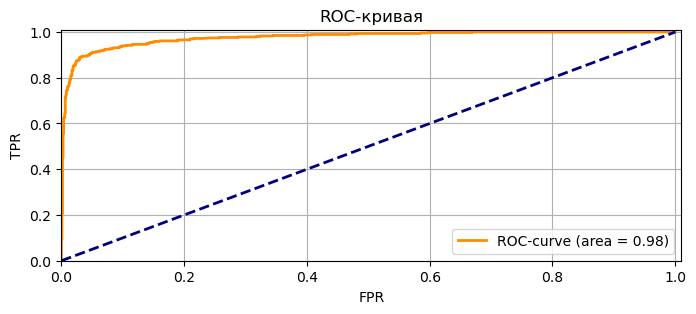

In [76]:
probabilities = best_model.decision_function(n2gram_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(8, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

ROC-кривая близка к идеальной, площадь под ROC-кривой -0.98.

In [77]:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1108
           1       0.88      0.91      0.89       463

    accuracy                           0.94      1571
   macro avg       0.92      0.93      0.92      1571
weighted avg       0.94      0.94      0.94      1571



Построим матрицу ошибок. Результаты модели хорошие, целевой класс "спам" ожидаемо определяется чуть хуже (recall ниже).

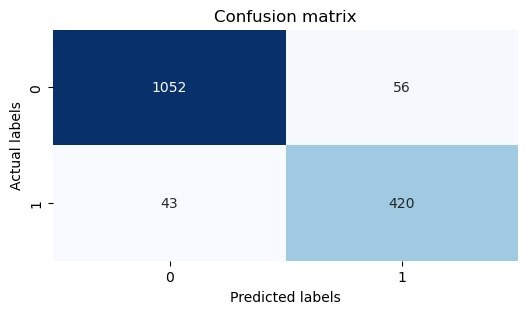

In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion matrix')
plt.show()

In [79]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
print("False Positive Rate (FPR):", round(fpr*100), '%')
print("False Negative Rate (FNR):", round(fnr*100), '%')

False Positive Rate (FPR): 5 %
False Negative Rate (FNR): 9 %


Метрика лучшей модели на тестовых данных *ROC-AUC=0.93*. Процент ошибок второго рода у модели выше, чем процент ошибок первого рода: модель чаще ошибается, определяя спам-текст как не спам, чем определяя неспам-текст как спам.

## Экспорт результатов

Для данных test сформируем csv-файл со следующим содержание: исходный текст - метка (ham, spam). test (дата-фрейм) уже содержит очищенный и лемматизированный текст - text_clean. Применим векторизацию и подставим данные в модель.

In [80]:
test.sample()

,text,text_clean
1818,rats hey did u ever vote for the next themes,rat ever vote next theme


In [86]:
vec_test = normalize(n2gram_vectorizer.transform(test['text_clean']), norm='l2')
predicted_labels = best_model.predict(vec_test)
test['score'] = predicted_labels

In [89]:
test['score'] = test['score'].map({1:'spam', 0:'ham'})

In [90]:
res_test = test[['score', 'text']]
res_test.sample()

,score,text
1957,ham,i sent them do you like


In [91]:
res_test.to_csv('test_results.csv', index=False)